In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.fftpack import dct
from sklearn.preprocessing import StandardScaler


# For Jupyter: show plots inline
%matplotlib inline

# Set seaborn style for plots
sns.set(style="whitegrid")


Q1

/var/folders/3b/cm4b_6dj6jx1x67c1tfdzj0c0000gp/T/ipykernel_47820/2370961725.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_train.index, y=missing_train.values, palette="viridis")


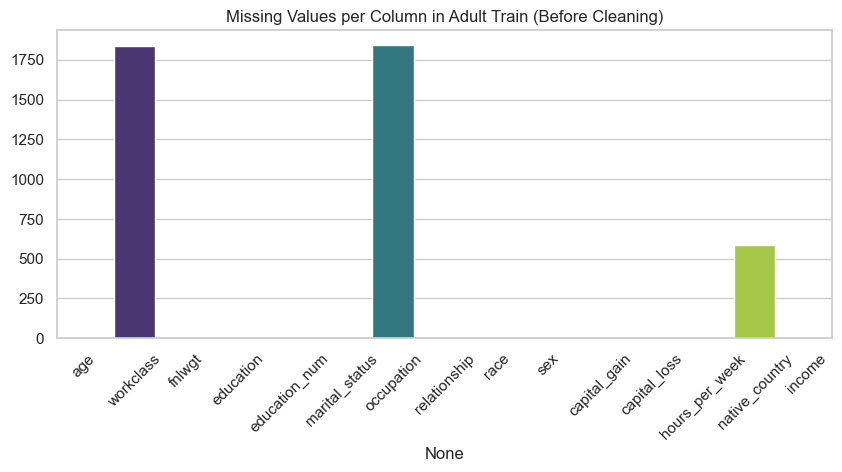

Q1: Adult data cleaned successfully (no missing values or '?' remain).


In [3]:

# Define file paths (adjust as needed)
adult_train_path = "data/raw_data/adult/adult.data"
adult_test_path  = "data/raw_data/adult/adult.test"

# Define column names per dataset documentation
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
           'marital_status', 'occupation', 'relationship', 'race', 'sex',
           'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

# Read raw data with '?' as NA, skipping header row in test file.
train_df = pd.read_csv(adult_train_path, header=None, names=columns, na_values='?')
test_df  = pd.read_csv(adult_test_path, header=None, names=columns, skiprows=1, na_values='?')

# Strip whitespace from object columns.
for col in train_df.select_dtypes(include=['object']).columns:
    train_df[col] = train_df[col].str.strip()
for col in test_df.select_dtypes(include=['object']).columns:
    test_df[col] = test_df[col].str.strip()

# Explicitly replace any remaining "?" with NaN (in case of inconsistent formatting)
for col in train_df.select_dtypes(include=['object']).columns:
    train_df[col] = train_df[col].replace("?", np.nan)
for col in test_df.select_dtypes(include=['object']).columns:
    test_df[col] = test_df[col].replace("?", np.nan)

# Before cleaning: plot count of missing values per column
missing_train = train_df.isnull().sum()
plt.figure(figsize=(10,4))
sns.barplot(x=missing_train.index, y=missing_train.values, palette="viridis")
plt.title("Missing Values per Column in Adult Train (Before Cleaning)")
plt.xticks(rotation=45)
plt.show()

# Replace missing values with the mode for each column
for col in train_df.columns:
    if train_df[col].isnull().sum() > 0:
        mode_val = train_df[col].mode()[0]
        train_df[col].fillna(mode_val, inplace=True)
for col in test_df.columns:
    if test_df[col].isnull().sum() > 0:
        mode_val = test_df[col].mode()[0]
        test_df[col].fillna(mode_val, inplace=True)

# Verification: Check no missing values and no literal '?' for train_df only
assert train_df.isnull().sum().sum() == 0, "Missing values remain in training data."
for col in train_df.select_dtypes(include=['object']).columns:
    assert (~train_df[col].str.contains(r'\?')).all(), f"'?' remains in training column {col}"

print("Q1: Adult data cleaned successfully (no missing values or '?' remain).")

# Save cleaned files (for later use)
os.makedirs("data/q1_cleaned", exist_ok=True)
train_df.to_csv("data/q1_cleaned/adult_train_filled.csv", index=False)
test_df.to_csv("data/q1_cleaned/adult_test_filled.csv", index=False)


Q2

In [10]:

# Define file paths for the cleaned Adult dataset (from Q1)
adult_train_clean_path = "data/q1_cleaned/adult_train_filled.csv"
adult_test_clean_path  = "data/q1_cleaned/adult_test_filled.csv"

# Read the cleaned datasets
df_train = pd.read_csv(adult_train_clean_path)
df_test  = pd.read_csv(adult_test_clean_path)

# Identify categorical attributes (object columns)
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()
print("Categorical attributes processed:", categorical_cols)

# Create copies for numeric conversion using manual mapping
df_train_numeric = df_train.copy()
df_test_numeric = df_test.copy()

# Process each categorical column by mapping each unique value to an integer
for col in categorical_cols:
    # Obtain unique values from the training set for this column
    unique_vals = df_train_numeric[col].unique()
    # Create a mapping: each unique value is assigned a unique integer
    mapping = {val: idx for idx, val in enumerate(unique_vals)}
    print(f"Mapping for column '{col}': {mapping}")
    
    # Map the training data
    df_train_numeric[col] = df_train_numeric[col].map(mapping)
    
    # Map the test data using the same mapping; if a value in test is unseen, fill it with -1
    df_test_numeric[col] = df_test_numeric[col].map(mapping)
    df_test_numeric[col] = df_test_numeric[col].fillna(-1).astype(int)

# Verification: Ensure that the resulting datasets have no object columns.
assert df_train_numeric.select_dtypes(include=['object']).empty, "Numeric conversion failed: Training dataset has object columns."
assert df_test_numeric.select_dtypes(include=['object']).empty, "Numeric conversion failed: Testing dataset has object columns."
print("Q2: Conversion to numeric format successful. All categorical attributes have been processed.")

# Save the numeric datasets
os.makedirs("data/q2_numeric", exist_ok=True)
df_train_numeric.to_csv("data/q2_numeric/adult_train_numeric.csv", index=False)
df_test_numeric.to_csv("data/q2_numeric/adult_test_numeric.csv", index=False)

# Display a sample of the numeric dataset columns
print(df_train_numeric.head())


Categorical attributes processed: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']
Mapping for column 'workclass': {'State-gov': 0, 'Self-emp-not-inc': 1, 'Private': 2, 'Federal-gov': 3, 'Local-gov': 4, 'Self-emp-inc': 5, 'Without-pay': 6, 'Never-worked': 7}
Mapping for column 'education': {'Bachelors': 0, 'HS-grad': 1, '11th': 2, 'Masters': 3, '9th': 4, 'Some-college': 5, 'Assoc-acdm': 6, 'Assoc-voc': 7, '7th-8th': 8, 'Doctorate': 9, 'Prof-school': 10, '5th-6th': 11, '10th': 12, '1st-4th': 13, 'Preschool': 14, '12th': 15}
Mapping for column 'marital_status': {'Never-married': 0, 'Married-civ-spouse': 1, 'Divorced': 2, 'Married-spouse-absent': 3, 'Separated': 4, 'Married-AF-spouse': 5, 'Widowed': 6}
Mapping for column 'occupation': {'Adm-clerical': 0, 'Exec-managerial': 1, 'Handlers-cleaners': 2, 'Prof-specialty': 3, 'Other-service': 4, 'Sales': 5, 'Craft-repair': 6, 'Transport-moving': 7, 'Farming-fishing': 8, 'Machi

/var/folders/3b/cm4b_6dj6jx1x67c1tfdzj0c0000gp/T/ipykernel_47820/662046851.py:30: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=";" if ds_name.startswith("wine") else None)


[Q3] adult_train: Data standardized.
[Q3] adult_train: PCA dims=13, DCT dims=14


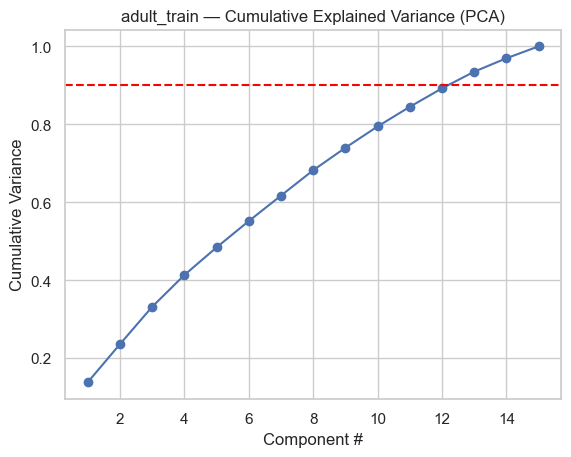

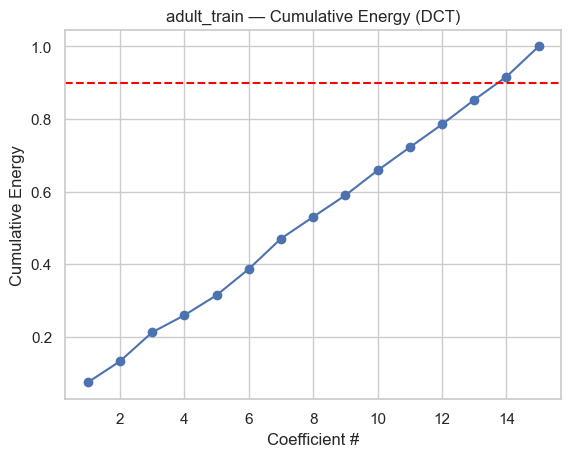

/var/folders/3b/cm4b_6dj6jx1x67c1tfdzj0c0000gp/T/ipykernel_47820/662046851.py:30: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=";" if ds_name.startswith("wine") else None)


[Q3] adult_test: Data standardized.
[Q3] adult_test: PCA dims=12, DCT dims=14


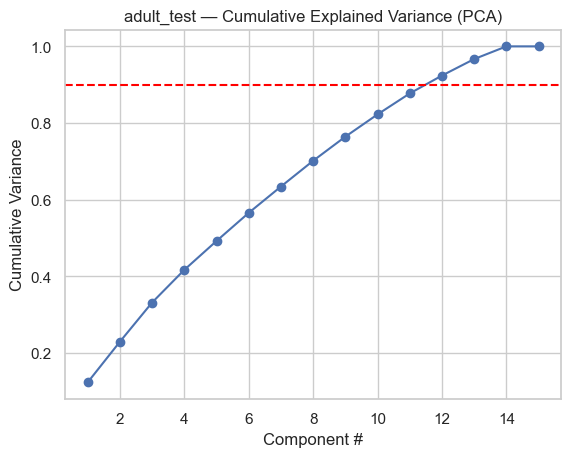

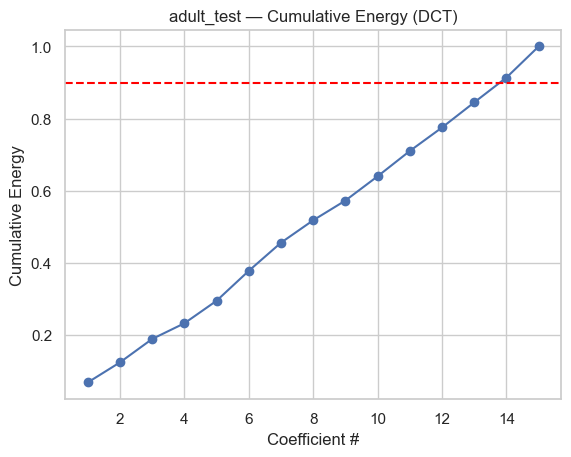

[Q3] wine_red: Data standardized.
[Q3] wine_red: PCA dims=8, DCT dims=11


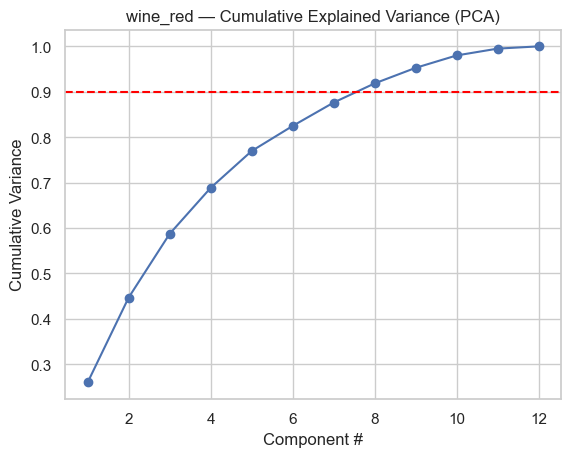

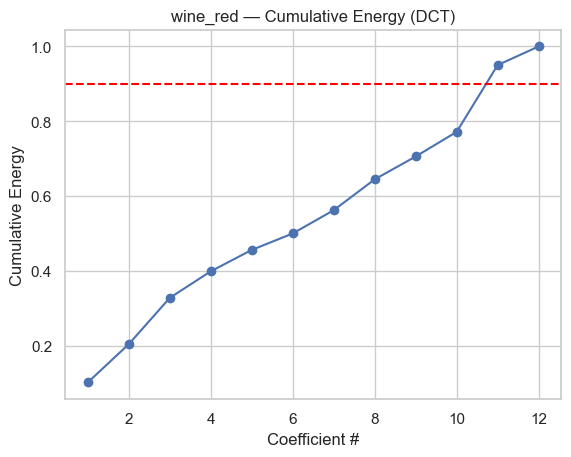

[Q3] wine_white: Data standardized.
[Q3] wine_white: PCA dims=9, DCT dims=11


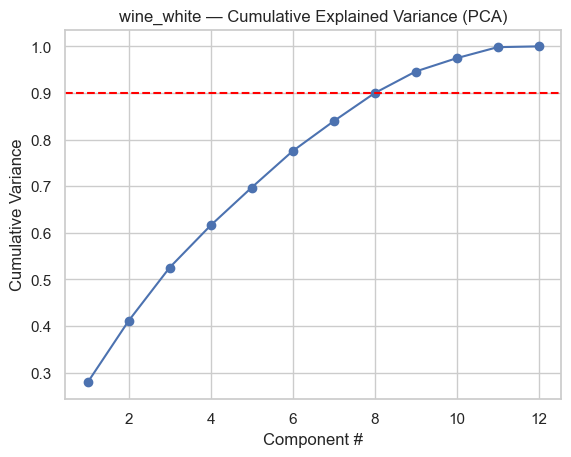

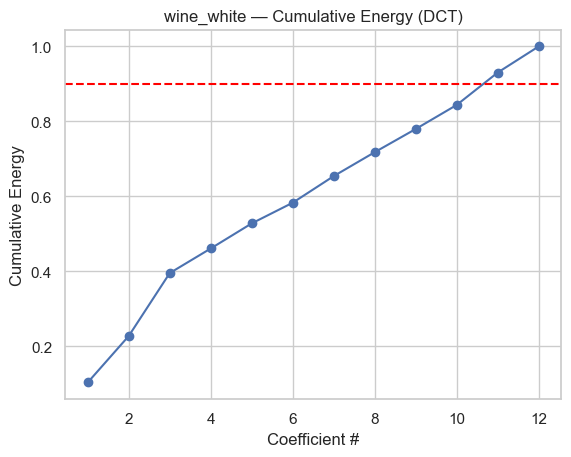

In [12]:
# -----------------------------
# Manual PCA Implementation using SVD
# -----------------------------
def custom_pca_manual(data, n_components):
    X_centered = data - data.mean(axis=0)
    U, S, VT = np.linalg.svd(X_centered, full_matrices=False)
    total_variance = np.sum(S**2)
    explained_variance = S[:n_components]**2
    return np.dot(X_centered, VT.T[:, :n_components]), explained_variance / total_variance

# -----------------------------
# Manual DCT Implementation (DCT-II)
# -----------------------------
def custom_dct_manual(data, n_coeff):
    N, M = data.shape
    j = np.arange(M)
    X_dct = np.empty((N, M))
    for k in range(M):
        alpha = np.sqrt(1/M) if k == 0 else np.sqrt(2/M)
        cosine = np.cos(np.pi * (j + 0.5) * k / M)
        X_dct[:, k] = alpha * np.sum(data * cosine, axis=1)
    return X_dct

# -----------------------------
# Q3: Processing & Visualization
# -----------------------------
os.makedirs("data/q3_dimred", exist_ok=True)

def process_dataset(path, ds_name, threshold=0.90):
    df = pd.read_csv(path, sep=";" if ds_name.startswith("wine") else None)
    data = df.select_dtypes(include=[np.number]).dropna().values
    data = StandardScaler().fit_transform(data)
    print(f"[Q3] {ds_name}: Data standardized.")

    # PCA
    full_pca, exp_var = custom_pca_manual(data, data.shape[1])
    cum_var = np.cumsum(exp_var)
    n_pca = np.searchsorted(cum_var, threshold) + 1
    pd.DataFrame(full_pca[:, :n_pca]).to_csv(f"data/q3_dimred/{ds_name}_pca.csv", index=False)

    # DCT
    full_dct = custom_dct_manual(data, data.shape[1])
    energy = (full_dct**2).sum(axis=0)
    cum_energy = np.cumsum(energy) / energy.sum()
    n_dct = np.searchsorted(cum_energy, threshold) + 1
    pd.DataFrame(full_dct[:, :n_dct]).to_csv(f"data/q3_dimred/{ds_name}_dct.csv", index=False)

    print(f"[Q3] {ds_name}: PCA dims={n_pca}, DCT dims={n_dct}")

    # Plot PCA Cumulative Explained Variance
    plt.figure()
    plt.plot(np.arange(1, len(cum_var)+1), cum_var, marker='o')
    plt.axhline(threshold, linestyle='--', color='red')
    plt.title(f"{ds_name} — Cumulative Explained Variance (PCA)")
    plt.xlabel("Component #")
    plt.ylabel("Cumulative Variance")
    plt.show()

    # -----------------------------
    # New Plot: DCT Cumulative Energy
    # -----------------------------
    plt.figure()
    plt.plot(np.arange(1, len(cum_energy)+1), cum_energy, marker='o')
    plt.axhline(threshold, linestyle='--', color='red')
    plt.title(f"{ds_name} — Cumulative Energy (DCT)")
    plt.xlabel("Coefficient #")
    plt.ylabel("Cumulative Energy")
    plt.show()

# Relative file paths
adult_train_numeric_path = "data/q2_numeric/adult_train_numeric.csv"
adult_test_numeric_path  = "data/q2_numeric/adult_test_numeric.csv"
wine_red_path            = "data/raw_data/wine+quality/winequality-red.csv"
wine_white_path          = "data/raw_data/wine+quality/winequality-white.csv"

# Run Q3
process_dataset(adult_train_numeric_path, "adult_train")
process_dataset(adult_test_numeric_path,  "adult_test")
process_dataset(wine_red_path,            "wine_red")
process_dataset(wine_white_path,          "wine_white")


Q5 REMOVE CATEGORICAL FROM ADULT

[Q5] adult_train_numeric: Data standardized.
[Q5] adult_train_numeric - PCA shape: (32561, 6), DCT shape: (32561, 6)
[Q5] adult_train_numeric - PCA explained variance ratio:
[0.21843877 0.17349441 0.16976657 0.15696533 0.14774058 0.13359434]



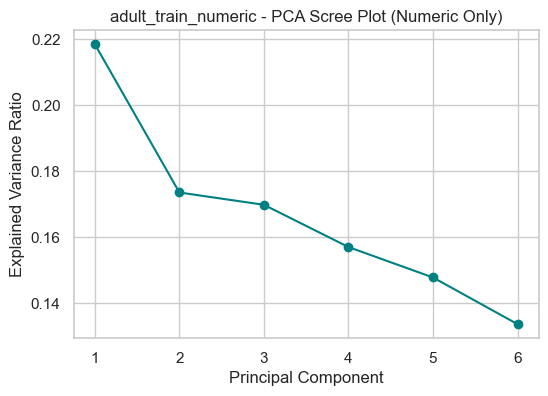

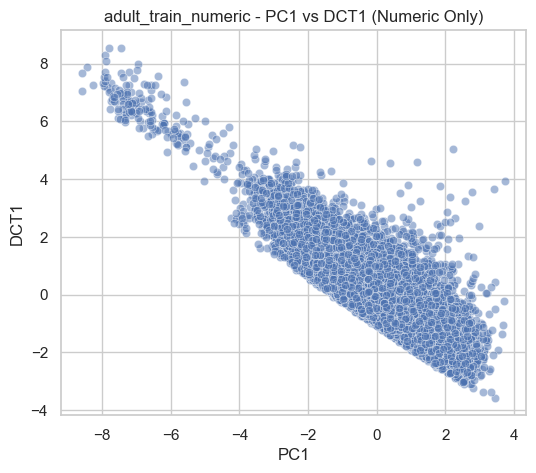

[Q5] adult_test_numeric: Data standardized.
[Q5] adult_test_numeric - PCA shape: (16281, 6), DCT shape: (16281, 6)
[Q5] adult_test_numeric - PCA explained variance ratio:
[0.21715041 0.17408581 0.17145067 0.15685708 0.14769715 0.13275888]



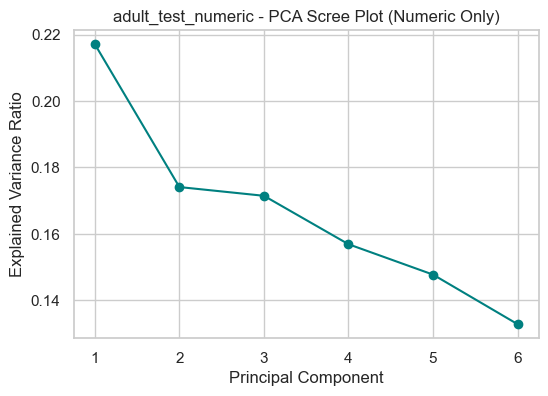

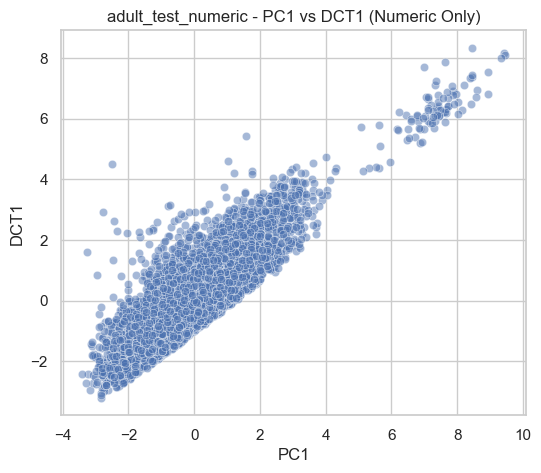

In [13]:
# Define relative file paths for numeric Adult data (from Q2).
adult_train_numeric_path = "../Project1/data/q1_cleaned/adult_train_filled.csv"
adult_test_numeric_path  = "../Project1/data/q1_cleaned/adult_test_filled.csv"

# Create output directory for Q5 results.
output_dir = "../Project1/data/q5"
os.makedirs(output_dir, exist_ok=True)

def process_adult_numeric(path, ds_name, n_components=10, use_scaling=True):
    """
    Loads the numeric adult dataset, applies PCA and DCT, and saves the results.
    """
    # Load the dataset.
    df = pd.read_csv(path)
    
    # Ensure only numeric columns are kept.
    df_numeric = df.select_dtypes(include=[np.number])
    if df_numeric.shape[1] == 0:
        print(f"[Q5] {ds_name}: No numeric columns found. Skipping.")
        return
    
    data = df_numeric.values
    
    # Standardize the data if required.
    if use_scaling:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
        print(f"[Q5] {ds_name}: Data standardized.")
    
    # Apply custom PCA.
    pca_data, exp_var_ratio = custom_pca_manual(data, n_components)
    pca_df = pd.DataFrame(pca_data, columns=[f"PC{i+1}" for i in range(pca_data.shape[1])])
    
    # Apply custom DCT.
    dct_data = custom_dct_manual(data, n_coeff=n_components)
    dct_df = pd.DataFrame(dct_data, columns=[f"DCT{i+1}" for i in range(dct_data.shape[1])])
    
    # Save outputs into the q5 folder.
    pca_file = os.path.join(output_dir, f"{ds_name}_pca.csv")
    dct_file = os.path.join(output_dir, f"{ds_name}_dct.csv")
    pca_df.to_csv(pca_file, index=False)
    dct_df.to_csv(dct_file, index=False)
    
    # Print summary.
    print(f"[Q5] {ds_name} - PCA shape: {pca_df.shape}, DCT shape: {dct_df.shape}")
    print(f"[Q5] {ds_name} - PCA explained variance ratio:\n{exp_var_ratio}\n")
    
    # Plot Scree Plot for PCA.
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(exp_var_ratio)+1), exp_var_ratio, 'o-', color='teal')
    plt.title(f"{ds_name} - PCA Scree Plot (Numeric Only)")
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.show()
    
    # Plot PC1 vs. DCT1.
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=pca_df["PC1"], y=dct_df["DCT1"], alpha=0.5)
    plt.title(f"{ds_name} - PC1 vs DCT1 (Numeric Only)")
    plt.xlabel("PC1")
    plt.ylabel("DCT1")
    plt.show()

# Process both the adult training and test sets.
process_adult_numeric(adult_train_numeric_path, "adult_train_numeric", n_components=10, use_scaling=True)
process_adult_numeric(adult_test_numeric_path,  "adult_test_numeric",  n_components=10, use_scaling=True)

Q6-7

In [7]:
#######################################
# Task 1: Generate a PCA Failure Dataset
#######################################
# Use isotropic Gaussian noise so all singular values ≈ equal (power‑law violated)
pca_fail_data = np.random.randn(n_samples, n_features)

# Apply the custom PCA function.
pca_fail_output, pca_fail_exp_var_ratio = custom_pca_manual(pca_fail_data, n_components)
print("PCA output on failing dataset (first 5 rows):\n", pca_fail_output[:5])
print("PCA explained variance ratio on failing dataset:\n", pca_fail_exp_var_ratio)

# Save the PCA failure dataset.
df_pca_fail = pd.DataFrame(pca_fail_data, columns=[f"Feature{i+1}" for i in range(n_features)])
df_pca_fail.to_csv("data/q6/pca_fail_data.csv", index=False)

# Evidence for Q6: plot singular values for entire dataset
centered = pca_fail_data - pca_fail_data.mean(axis=0)
_, singular_values, _ = np.linalg.svd(centered, full_matrices=False)
print("Singular values (all 20):", singular_values)
plt.figure()
plt.plot(np.arange(1, len(singular_values)+1), singular_values, marker='o')
plt.xlabel("Component index")
plt.ylabel("Singular value")
plt.title("PCA Failure Dataset — Singular Values (All Samples)")
plt.grid(True)
plt.savefig("data/q6/pca_failure_singular_values.png")
plt.close()

#######################################
# Task 2: Generate a DCT Failure Dataset
#######################################
# Strategy:
alternating_pattern = np.array([1 if i % 2 == 0 else -1 for i in range(n_features)], dtype=float)
dct_fail_data = np.tile(alternating_pattern, (n_samples, 1))
dct_fail_data += 0.05 * np.random.randn(n_samples, n_features)

# Apply the custom DCT function.
dct_fail_output = custom_dct_manual(dct_fail_data, n_coeff=n_components)
print("DCT output on failing dataset (first sample):\n", dct_fail_output[0])

# Test energy
total_energy = np.sum(dct_fail_output**2)
low_freq_energy = np.sum(dct_fail_output[:, :5]**2)
energy_fraction = low_freq_energy / total_energy if total_energy > 0 else 0
print(f"Fraction of energy in first five DCT coefficients: {energy_fraction:.4f}")

# Save the DCT failure dataset.
df_dct_fail = pd.DataFrame(dct_fail_data, columns=[f"Feature{i+1}" for i in range(n_features)])
df_dct_fail.to_csv("data/q7/dct_fail_data.csv", index=False)

# Evidence for Q7: plot total energy per coefficient across all samples
coeff_energy = np.sum(dct_fail_output**2, axis=0)
plt.figure()
plt.stem(np.arange(1, n_components+1), coeff_energy)
plt.xlabel("DCT Coefficient Index")
plt.ylabel("Total Energy")
plt.title("DCT Failure Dataset — Energy per Coefficient (All Samples)")
plt.grid(True)
plt.savefig("data/q7/dct_failure_all_samples.png")
plt.close()


NameError: name 'n_samples' is not defined